# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Streaming Processing** </center>
---

**Date**: November 23, 2025

**Student Name**: Axel Leonardo Fernandez Albarran

**Professor**: Pablo Camarillo Ramirez

## Generador de Rides

Esta dentro de lib/axel_fernandez/final_project.  --> producer_rides.csv
Dentro del script podemos cambiar el tiempo de creacion, id, etc. 

En esencia solo se crea este script ya que al tener diferentes drivers nosotros nos enfocaremos en la movilidad dentro de la ciudad atravez de los rides para poder dar predicciones de los viajes que se realizan por la ciudad,precios, etc. Este script usa los ID's que esta dentro del dataset descargado de kagle el cual es "Cityride Drivers Data.csv".

Se decide usar csv como metodo de salida para leerlo de manera mas facil ya que so multiples filas de datos que son extraidas. cada csv se considera que es en tiempo real una batch de rides que se realizaron por lo que en un escenario real esto sucederia cada segundo pero en nuestro caso lo haremos cada 5 a 10 segundos para poder analizarlo de mejor manera

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Structured Streaming (files)") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/23 06:55:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Dataset and Stream creation

In [2]:
from axel_fernandez.schema_generator import SchemaGenerator

rides_schema = SchemaGenerator.get_rides_schema()
drivers_schema = SchemaGenerator.get_drivers_schema()

# Cargamos el dataset de drivers y eliminamos duplicados para poder hacer el join posteriormente con lo generado del productor de rides
drivers_path = "/opt/spark/work-dir/data/final_project/Cityride Drivers Data.csv"
drivers_df = spark.read.option("header", True).schema(drivers_schema).csv(drivers_path).dropDuplicates(["Driver_ID"])
drivers_df = drivers_df.withColumnRenamed("Driver_ID", "Driver_ID_lookup") # para evitar conflicto en el join posterior

In [3]:
def process_batch(batch_df, batch_id):
    # Hacemos join de cada batch con los drivers dependiendo el driver id del dataset original cargado
    # Eliminamos las columnas innecesarias para no cargarlo en el archivo persistente
    enriched = batch_df.join(drivers_df, batch_df.Driver_ID == drivers_df.Driver_ID_lookup, how="left") \
                .drop("Driver_ID_lookup","Age","City","Experience_Years","Average_Rating","Active_Status")
    # Agregamos el parquet al directorio para hacer las transformaciones posteriores a la finalizacion del stream
    enriched.write.mode("append").parquet("/opt/spark/work-dir/data/final_project/processed/rides_parquet/")

rides_df = spark.readStream \
    .format("csv") \
    .option("header", "true") \
    .option("sep", ",") \
    .schema(rides_schema) \
    .load("/opt/spark/work-dir/data/final_project/producer/rides/")

query = rides_df.writeStream \
    .foreachBatch(process_batch) \
    .option("checkpointLocation", "/opt/spark/work-dir/data/final_project/checkpoints/rides_foreachBatch/") \
    .start()

query.awaitTermination(20)
query.stop()

# Transformations and Actions

In [4]:
from pyspark.sql.functions import col, trim, lower, when, to_date, lit, ceil, round

# Obtenemos todos los parquets generados por el streaming y hacemos las transformaciones finales
processed_df = spark.read.parquet("/opt/spark/work-dir/data/final_project/processed/rides_parquet/")
rides_clean_df = (
    processed_df
    .dropDuplicates(["Ride_ID"])
    .withColumnRenamed("Ride_City", "City")
    .withColumn("City", lower(trim(col("City"))))
    .withColumn("Date", trim(col("Date")))
    .withColumn("Promo_Code", when((col("Promo_Code").isNull()) | (trim(col("Promo_Code")) == ""), lit("NO_PROMO"))
                              .otherwise(trim(col("Promo_Code"))))
    .filter(col("Ride_ID").isNotNull() & col("Driver_ID").isNotNull() & col("Date").isNotNull())
    .filter((col("Distance_km") >= 0) & (col("Duration_min") >= 0) & (col("Fare") >= 0))
    .filter(col("Rating").between(0.0, 5.0))
    .withColumn("Rating", ceil(col("Rating")).cast("int"))
    .withColumn("Date", to_date(trim(col("Date")), "MM/dd/yyyy"))
    .withColumn("fare_per_km", when(col("Distance_km") > 0,
                                    round(col("Fare").cast("double") / col("Distance_km").cast("double"), 2))
                                   .otherwise(lit(None)))
)

# Persistence Data

### Particion Horizontal

In [9]:
# Donde seran guardados los archivos finales particionados
output_base = "/opt/spark/work-dir/data/final_project/processed/final_output"

# parquet particionado
rides_clean_df.write \
    .mode("append") \
    .option("compression", "snappy") \
    .partitionBy("Date") \
    .parquet(f"{output_base}/parquet/")

# csv particionado
rides_clean_df.write \
    .mode("append") \
    .option("header", "true") \
    .partitionBy("Date") \
    .csv(f"{output_base}/csv/")

print("Wrote parquet and csv partitioned by Date to:", output_base)


Wrote parquet and csv partitioned by Date to: /opt/spark/work-dir/data/final_project/processed/final_output


### Partición Vertical

In [10]:
vertical_base = f"{output_base}/vertical_partition"

# Datos principales del viaje
df_main = rides_clean_df.select("Ride_ID", "Date", "City", "Distance_km","Duration_min", "Rating")
df_main.write \
    .mode("append") \
    .parquet(f"{vertical_base}/rides_info/")

# Datos financieros
df_finance = rides_clean_df.select("Ride_ID", "Fare", "Promo_Code", "fare_per_km")
df_finance.write \
    .mode("append") \
    .parquet(f"{vertical_base}/rides_finance/")

print("Wrote vertical partitions to:", vertical_base)

Wrote vertical partitions to: /opt/spark/work-dir/data/final_project/processed/final_output/vertical_partition


### CSV sin particionar para usarlo dentro de powerBI. 

Debido a que todavía no entiendo al 100% Power BI y estoy trabajando en la versión web desde una Mac, no encontré la manera de leer todas las carpetas generadas por la partición del dataframe. Por eso, usando el mismo DF, decidí guardarlo en un solo archivo CSV con todos los registros juntos y trabajar con ese archivo para construir mi dashboard en Power BI.


In [7]:
output_report = "/opt/spark/work-dir/data/final_project/processed/reporting/rides_consolidated"

rides_clean_df.write \
    .mode("overwrite") \
    .option("header", "true") \
    .csv(output_report)

print(f"File created sucesfully for powerBI on: {output_report}")

File created sucesfully for powerBI on: /opt/spark/work-dir/data/final_project/processed/reporting/rides_consolidated


# Power BI Dashboard 

En este caso he realizado las 6 siguientes graficas:

* **Top 10 Conductores mejor calificados:** rating promedio de los mejores drivers.
* **Top 5 conductores con mejor ganancia:** suma ingresos totales por conductor.
* **Ciudad con mayor ingresos:** compara ingresos totales generados por ciudad.
* **Códigos promocionales usados:** distribución porcentual de viajes por tipo promo.
* **Rides por mes:** cantidad de viajes realizados en cada mes.
* **Relación Distancia vs Tarifa:** relaciona kilómetros recorridos contra tarifa cobrada.

Cada una de estas gráficas ofrece una vista clara y rápida de los datos, y a partir de ellas se pueden generar muchas otras visualizaciones según las necesidades del análisis.

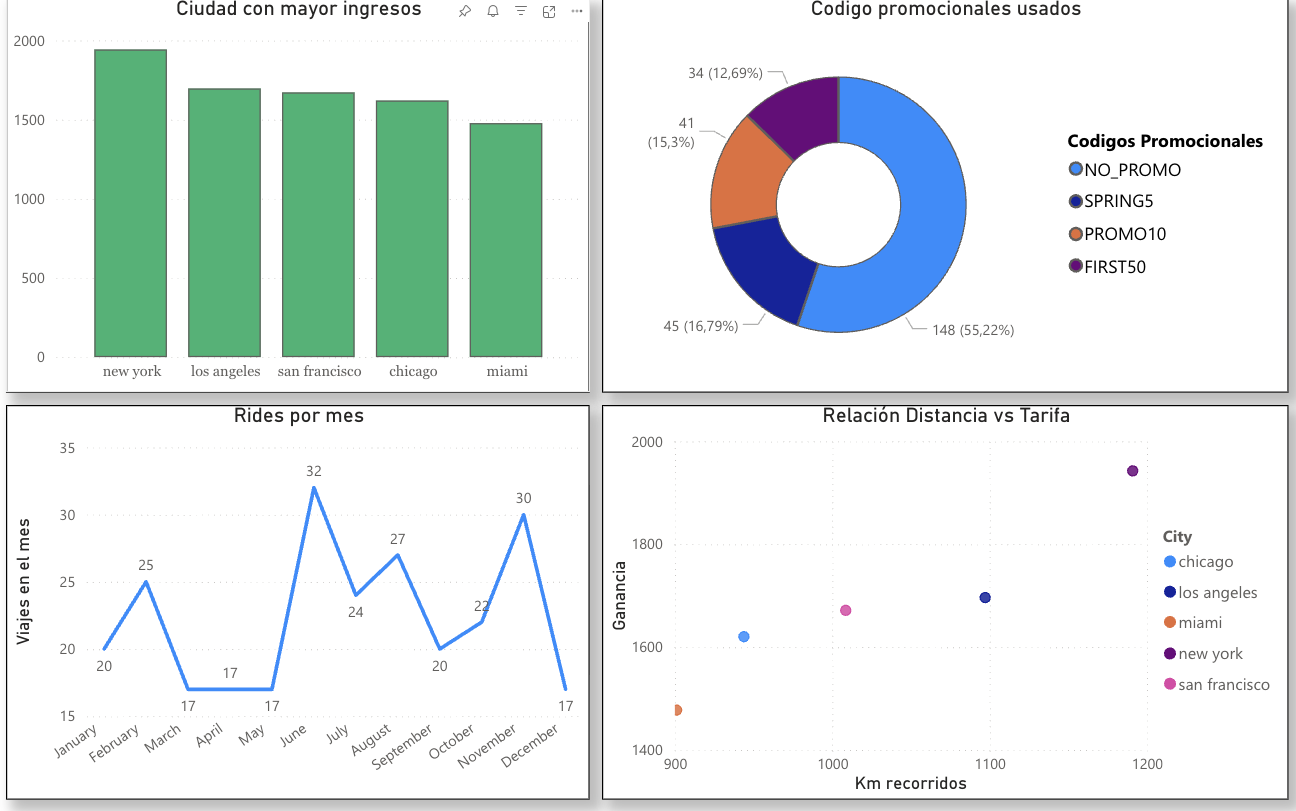

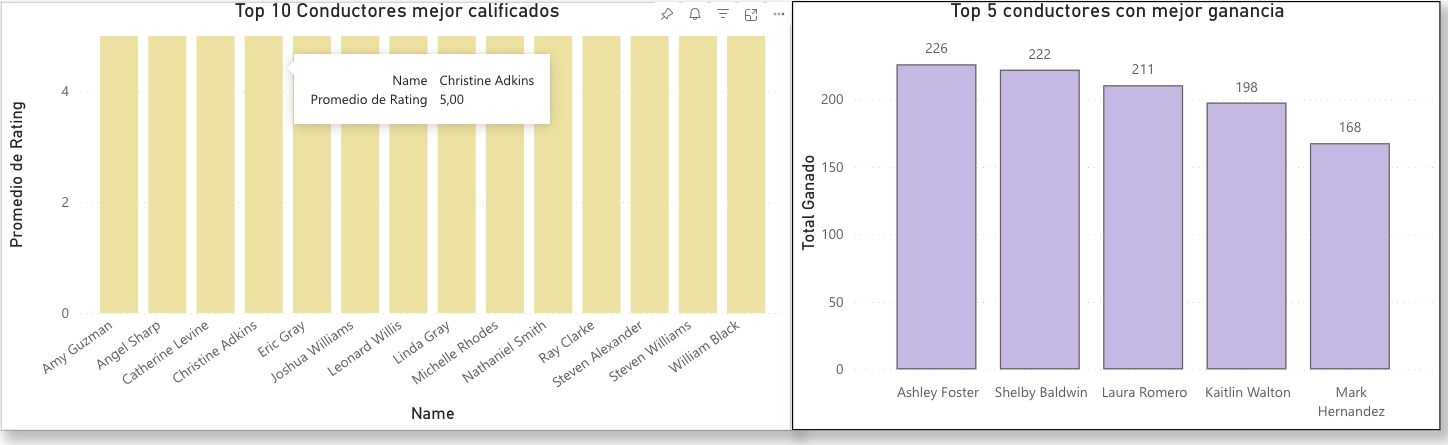

## Visualizacion de todos los datos generados en este notebook
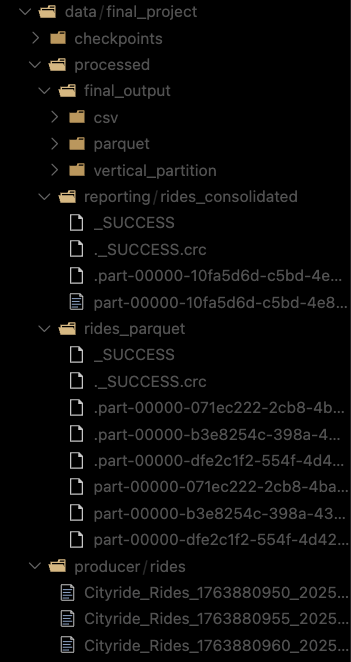
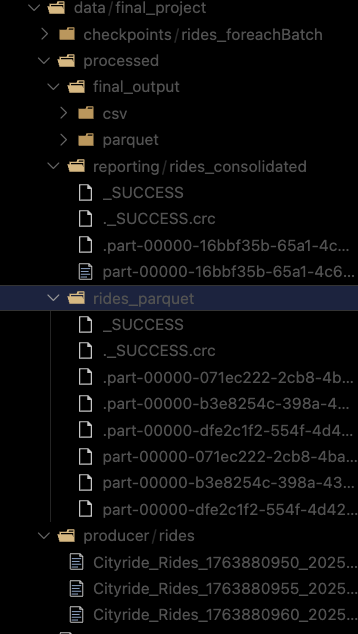